# Finetuning

This tutorial illustrates how to fine-tune the `GR00T-N1` pretrained checkpoint on a post-training 
dataset using the same embodiment. This showcases the benefit of post-training, transforming a generalist model into a specialist and demonstrating a performance gain.

For this tutorial, we will use the demo dataset `robot_sim.PickNPlace` from the [demo_data](./demo_data) folder. 

We will first load the pre-trained model and evaluate it on the dataset. Then we will finetune the model on the dataset and evaluate the performance.

## Pre-trained Model

In [2]:
from gr00t.utils.eval import calc_mse_for_single_trajectory
import warnings
from gr00t.experiment.data_config import DATA_CONFIG_MAP
from gr00t.model.policy import Gr00tPolicy
from gr00t.data.schema import EmbodimentTag
from gr00t.data.dataset import LeRobotSingleDataset
import numpy as np
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

warnings.simplefilter("ignore", category=FutureWarning)

Model not found or avail in the huggingface hub. Loading from local path: /mnt/amlfs-01/home/yufa/repos/GR00T-N1-2B
Loading pretrained dual brain from /mnt/amlfs-01/home/yufa/repos/GR00T-N1-2B
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: /mnt/amlfs-01/home/yufa/repos/GR00T-N1-2B
Total number of DiT parameters:  537803776


Some weights of the model checkpoint at /mnt/amlfs-01/home/yufa/repos/GR00T-N1-2B were not used when initializing GR00T_N1: ['action_head.decode_layer.bias', 'action_head.decode_layer.weight']
- This IS expected if you are initializing GR00T_N1 from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GR00T_N1 from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Tune action head projector: True
Tune action head diffusion model: True
Tune action head projector: True
Tune action head diffusion model: True
Failed to load dataset statistics: 1 validation error for DatasetStatisticalValues
  Input should be a valid dictionary or instance of DatasetStatisticalValues [type=model_type, input_value=1000, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/model_type
Calculating dataset statistics for gr1_unified.PnPMilkToMicrowaveClose


Computing statistics for observation.state...
Computing statistics for action...
Computing statistics for timestamp...
Computing statistics for next.reward...
Computing statistics for next.done...
Computing statistics for task_index...
Computing statistics for annotation.human.fine_action...
Computing statistics for annotation.human.coarse_action...
Computing statistics for episode_index...
Computing statistics for index...
Initialized dataset gr1_unified.PnPMilkToMicrowaveClose with EmbodimentTag.GR1
inferencing at step:  0


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
inferencing at step:  160
inferencing at step:  176
inferencing at step:  192
inferencing at step:  208
inferencing at step:  224
inferencing at step:  240
inferencing at step:  256
inferencing at step:  272
inferencing at step:  288
inferencing at step:  304
inferencing at step:  320
inferencing at step:  336
inferencing at step:  352
inferencing at step:  368
inferencing at step:  384
inferencing at step:  400
inferencing at step:  416
inferencing at step:  432
inferencing at step:  448
inferencing at step:  464
inferencing at step:  480
inferencing at step:  496
inferencing at step:  512
inferencing at step:  528
inferencing at step:  544
inferencing at step:  560
inferencing at step:  576
inferencing at step:  592
inferencing at step:  608
inferencing at ste

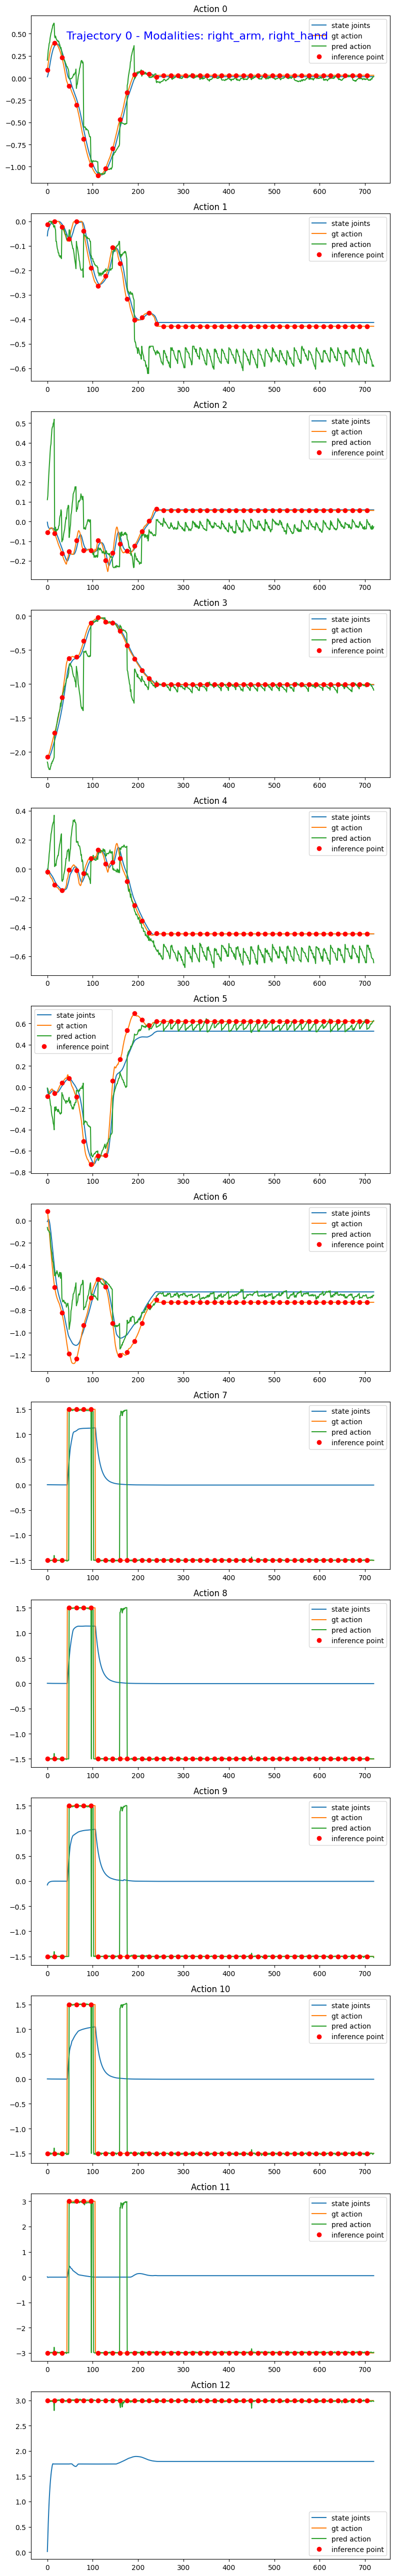

MSE loss for trajectory 0: 0.19875432011063485


In [3]:
PRE_TRAINED_MODEL_PATH = "/mnt/amlfs-01/home/yufa/repos/GR00T-N1-2B"
EMBODIMENT_TAG = EmbodimentTag.GR1
DATASET_PATH = "/mnt/amlfs-01/home/yufa/shared/datasets/dc_official_1000_lerobot/gr1_unified.PnPMilkToMicrowaveClose"


data_config = DATA_CONFIG_MAP["gr1_arms_waist"]
modality_config = data_config.modality_config()
modality_transform = data_config.transform()


pre_trained_policy = Gr00tPolicy(
    model_path=PRE_TRAINED_MODEL_PATH,
    embodiment_tag=EMBODIMENT_TAG,
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

dataset = LeRobotSingleDataset(
    dataset_path=DATASET_PATH,
    modality_configs=modality_config,
    video_backend="decord",
    video_backend_kwargs=None,
    transforms=None,  # We'll handle transforms separately through the policy
    embodiment_tag=EMBODIMENT_TAG,
)


mse = calc_mse_for_single_trajectory(
    pre_trained_policy,
    dataset,
    traj_id=0,
    modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
    steps=720,
    action_horizon=16,
    plot=True
)

print("MSE loss for trajectory 0:", mse)

Great! we can see the predicted actions and the ground truth actions. The predicted actions are not perfect but they are close to the ground truth actions. That's show that the pretrained checkpoint is working well.

Now let's sample 10 random trajectories and calcuate the mean MSE to get a sense of more verbose results.

In [4]:
total_trajectories = len(dataset.trajectory_lengths)

print("Total trajectories:", total_trajectories)

sampled_trajectories = np.random.choice(total_trajectories, 10)
print("Sampled trajectories:", sampled_trajectories)

all_mses = []

for traj_id in sampled_trajectories:
    mse = calc_mse_for_single_trajectory(
        pre_trained_policy,
        dataset,
        traj_id=traj_id,
        modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
        steps=150,
        action_horizon=16,
        plot=False
    )
    print(f"Trajectory {traj_id} MSE: {mse:.4f}")
    
    all_mses.append(mse)

print("====================================")
print("Mean MSE:", np.mean(all_mses))
print("Std MSE:", np.std(all_mses))


Total trajectories: 1000
Sampled trajectories: [836 517 569 349 475 729 104   2 377 730]
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 0.8691729425001076
Trajectory 836 MSE: 0.8692
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 0.18667567047358435
Trajectory 517 MSE: 0.1867
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128


## Finetuning the Model

Now we will finetune the model on the dataset. Without going into the details of the finetuning process, we will use the `gr00t_finetune.py` script to finetune the model. You can run the following command to finetune the model. 

```bash
python scripts/gr00t_finetune.py --dataset-path ./demo_data/robot_sim.PickNPlace --num-gpus 1 --max-steps 500 --output-dir /tmp/gr00t-1/finetuned-model --data-config gr1_arms_only
```

_To get a full list of the available arguments, you can run `python scripts/gr00t_finetune.py --help`._

The script will save the finetuned model in the `/tmp/gr00t-1/finetuned-model` directory. We will load the finetuned model with `500` checkpoint steps.  

### Evaluation of the Fine-tuned Model

Now we can evaluate the fine-tuned model by running the policy on the dataset and see how well it performs. We will use a utility function to evaluate the policy on the dataset. This is similar to the previous tutorial in [1_pretrained_model.ipynb](1_pretrained_model.ipynb)

Model not found or avail in the huggingface hub. Loading from local path: /tmp/gr00t-1/finetuned-model/checkpoint-500
Loading pretrained dual brain from /tmp/gr00t-1/finetuned-model/checkpoint-500
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: /tmp/gr00t-1/finetuned-model/checkpoint-500
Total number of DiT parameters:  537803776
Tune action head projector: True
Tune action head diffusion model: True


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


Tune action head projector: True
Tune action head diffusion model: True
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 0.23701904003396018


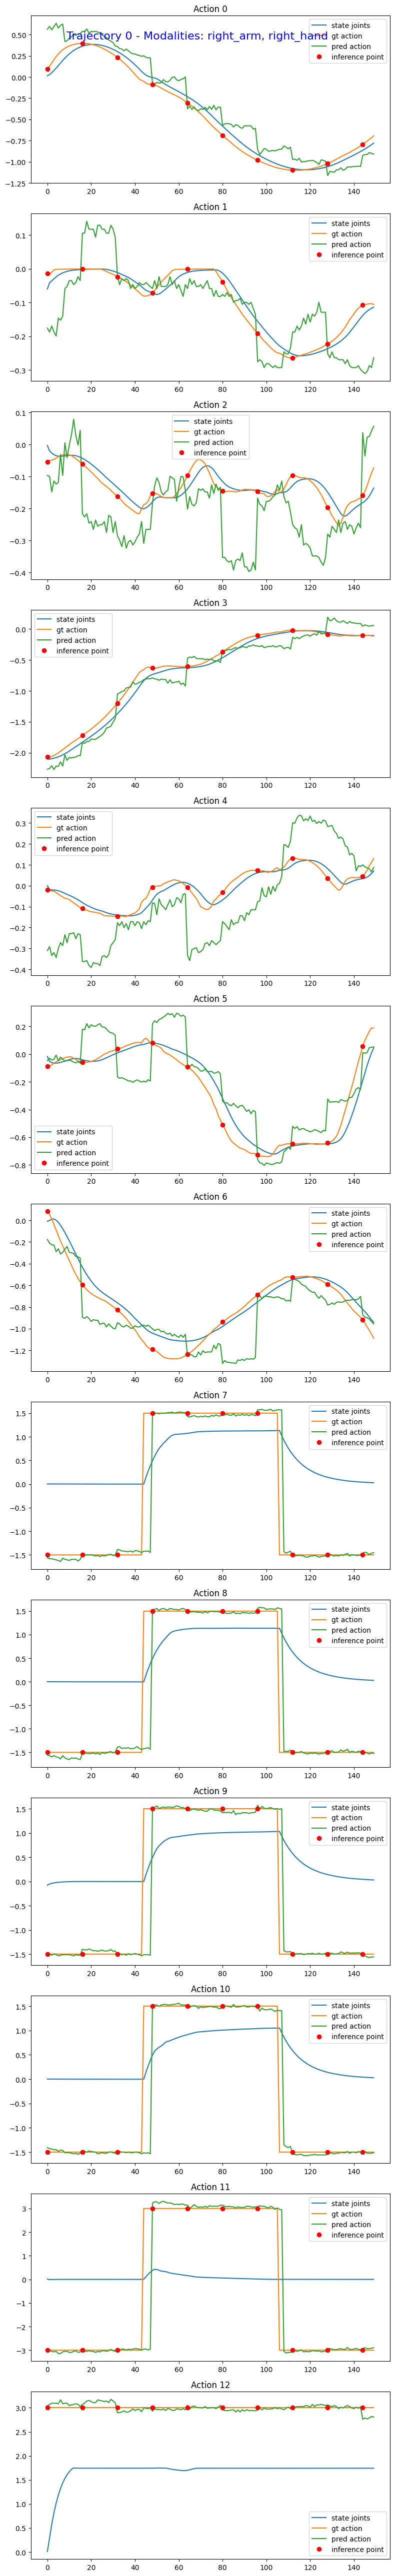

MSE loss for trajectory 0: 0.23701904003396018
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 0.9489009012186733


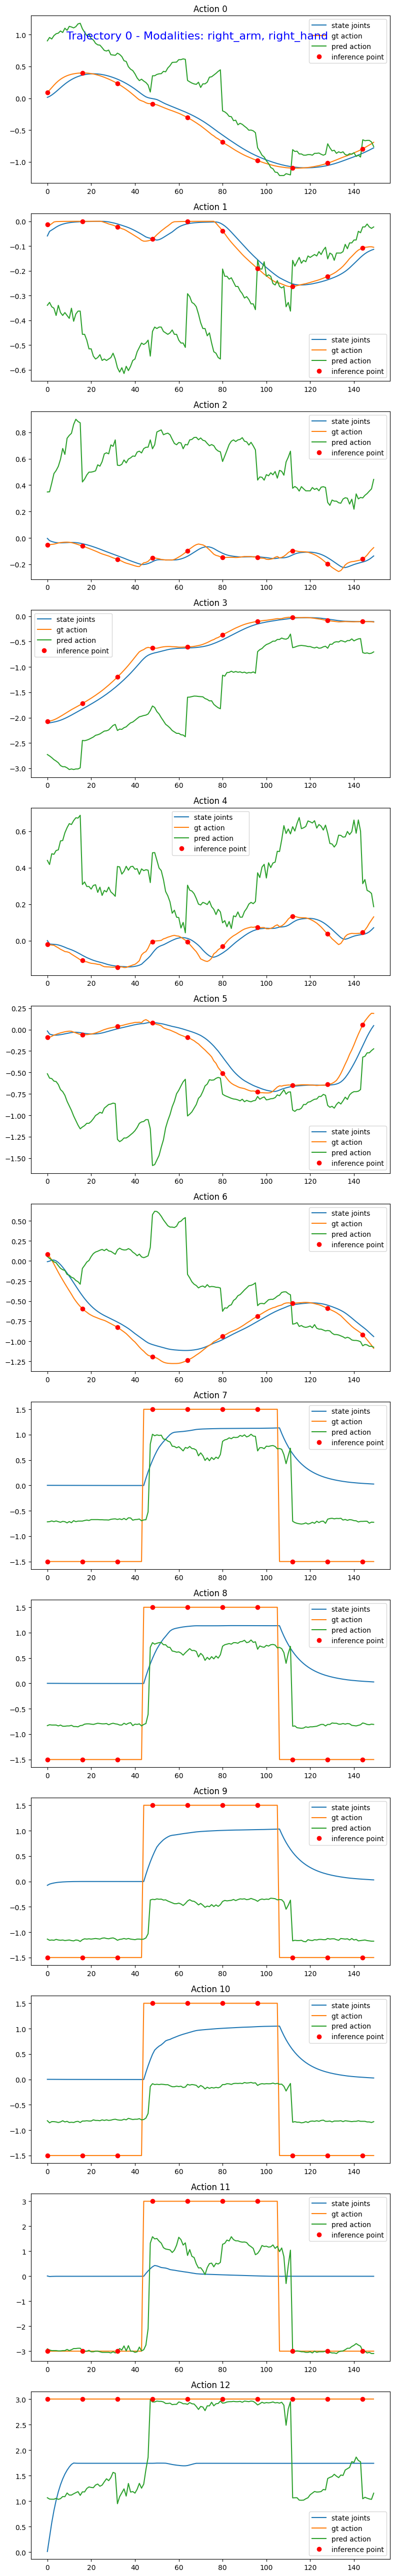

MSE loss for trajectory 0 (pretrain): 0.9489009012186733


In [7]:
from gr00t.utils.eval import calc_mse_for_single_trajectory
import warnings

finetuned_model_path = "/tmp/gr00t-1/finetuned-model/checkpoint-500"
finetuned_policy = Gr00tPolicy(
    model_path=finetuned_model_path,
    embodiment_tag="new_embodiment",
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

warnings.simplefilter("ignore", category=FutureWarning)

mse = calc_mse_for_single_trajectory(
    finetuned_policy,
    dataset,
    traj_id=0,
    modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
    steps=150,
    action_horizon=16,
    plot=True
)

print("MSE loss for trajectory 0:", mse)

mse = calc_mse_for_single_trajectory(
    pre_trained_policy,
    dataset,
    traj_id=0,
    modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
    steps=150,
    action_horizon=16,
    plot=True
)

print("MSE loss for trajectory 0 (pretrain):", mse)

Yaay! We have finetuned the model and evaluated it on the dataset. We can see that the model has learned the task and is able to perform the task better than the pre-trained model.